# MNIST Combiner

Combines two models, an SKLearn model and a Tensorflow model for MNIST. The combination does a simple average of the two models.

In [1]:
!pygmentize MnistCombiner.py

import logging
logger = logging.getLogger(__name__)

class MnistCombiner(object):
    def __init__(self, metrics_ok=True):
        print("MNIST Combiner Init called")

    def aggregate(self, Xs, features_names):
        print("MNIST Combiner aggregate called")
        logger.info(Xs)
        return (Xs[0]+Xs[1])/2.0


## Start Minikube

In [ ]:
!minikube start --memory 4096

In [2]:
!kubectl create clusterrolebinding kube-system-cluster-admin --clusterrole=cluster-admin --serviceaccount=kube-system:default

clusterrolebinding.rbac.authorization.k8s.io/kube-system-cluster-admin created


In [3]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "minikube" modified.


## Build Combiner image

In [4]:
!eval $(minikube docker-env) && s2i build -E environment_rest . seldonio/seldon-core-s2i-python36:0.18 seldonio/mnistcombiner_rest:0.1

---> Installing application source...
Build completed successfully


## Setup Seldon Core

Use the setup instructions to setup [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

In [1]:
%matplotlib inline
import utils
from visualizer import get_graph
mnist = utils.download_mnist()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


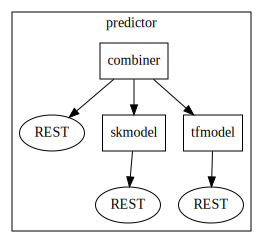

In [14]:
get_graph("mnist_combiner.json")

In [15]:
!pygmentize mnist_combiner.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "name": "mnistcombo"
    },
    "spec": {
        "name": "mnistcombo",
        "oauth_key": "oauth-key",
        "oauth_secret": "oauth-secret",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/sk-mnist:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "skmodel"
                            },
                            {
                                "image": "seldonio/deep-mnist:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "tfmodel"
                            },
                            {
                                "image": "seldonio/mnistcombiner_rest:0.1

In [16]:
!kubectl apply -f mnist_combiner.json

seldondeployment.machinelearning.seldon.io/mnistcombo created


In [18]:
!kubectl rollout status deploy/mnistcombo-mnistcombo-aacd66a

Waiting for deployment "mnistcombo-mnistcombo-aacd66a" rollout to finish: 0 of 1 updated replicas are available...
deployment "mnistcombo-mnistcombo-aacd66a" successfully rolled out


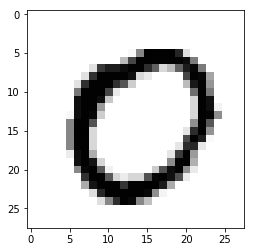

{'meta': {'puid': 'gdqbdu064ae8qnl7cf8g1l9ceb', 'tags': {}, 'routing': {'combiner': -1}, 'requestPath': {'tfmodel': 'seldonio/deep-mnist:0.1', 'skmodel': 'seldonio/sk-mnist:0.1', 'combiner': 'seldonio/mnistcombiner_rest:0.1'}, 'metrics': []}, 'data': {'names': ['t:0', 't:1', 't:2', 't:3', 't:4', 't:5', 't:6', 't:7', 't:8', 't:9'], 'ndarray': [[0.9853938817977905, 3.674550247412256e-11, 1.44667967560963e-06, 1.756110691530921e-06, 3.302479845146422e-09, 0.014028188772499561, 2.3320741604493378e-07, 7.86559226639838e-08, 0.0005743441870436072, 5.9187676981764525e-08]]}}


In [2]:
utils.predict_rest_mnist(mnist,"mnistcombo","seldon")